In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds
import lfimodels.hodgkinhuxley.utils as utils
import matplotlib.pyplot as plt
import numpy as np

from lfimodels.hodgkinhuxley.HodgkinHuxley import HodgkinHuxley
from lfimodels.hodgkinhuxley.HodgkinHuxleyStatsMoments import HodgkinHuxleyStatsMoments
from delfi.utils.viz import plot_pdf

%matplotlib inline

In [2]:
true_params, labels_params = utils.obs_params()

seed = 1
m = HodgkinHuxley(seed=seed)
p = utils.prior(true_params=true_params, seed=seed)
s = HodgkinHuxleyStatsMoments()
g = dg.Default(model=m, prior=p, summary=s)

true_params, labels_params = utils.obs_params()
obs = utils.obs_data(true_params, seed=seed)
obs_stats = utils.obs_stats(true_params, seed=seed)

In [3]:
seed = 1
g = dg.Default(model=m, prior=p, summary=s)
res = infer.CDELFI(g, obs=obs_stats, n_hiddens=[50], seed=seed)

# run with N samples
out = res.run(1000, n_rounds=1)

In [4]:
posterior = res.predict(obs_stats)

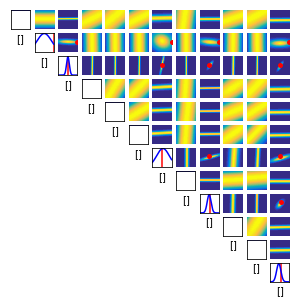

In [7]:
plot_pdf(posterior.xs[0], lims=[-5, 5], samples=None, gt=true_params);

In [ ]:
posterior.xs[0].m